## import libary

In [1]:
# import the libaries 
import pandas as pd
import numpy as np
import arabic_reshaper
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
import plotnine
import sklearn
from wordcloud import WordCloud
import collections
## for plotting
import wordcloud
## for text processing
import re
import nltk 
## for sentiment
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import defaultdict

## daownload data

In [2]:
df= pd.read_csv("../../Sentiment-Analysis-for-e-commerce-Apps-Reviews/data/app_data4.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24749 entries, 0 to 24748
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AppName            24749 non-null  object 
 1   date               24749 non-null  object 
 2   time               24749 non-null  object 
 3   PmAm               24749 non-null  object 
 4   title              24749 non-null  object 
 5   userName           24749 non-null  object 
 6   rating             24749 non-null  int64  
 7   review             24749 non-null  object 
 8   isEdited           24749 non-null  bool   
 9   developerResponse  8346 non-null   object 
 10  OverallRate        24749 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 1.9+ MB


In [7]:
df.sample(5)

,AppName,date,time,PmAm,title,userName,rating,review,isEdited,developerResponse,OverallRate
16304,aliexpress,29/11/2022 0:00,4:14:19,AM,Why 3 stars,Giginayarit,3,I give this app 3 starts because it has to do ...,False,Giginayarit,4.5
22539,asos,02/04/2021 0:00,9:01:07,PM,Great selection and customer service.,Lili Larose,5,ASOS has many of my favourite brands all on on...,False,NaN,4.7
191,shein,02/09/2022 0:00,1:12:49,PM,Helped me fill out my wardrobe!!,Turner319,5,"After I got my first paycheck, I wanted to fin...",False,NaN,3.6
15379,aliexpress,28/10/2021 0:00,5:02:45,AM,Be careful,mindi joy newman,5,Great app. But you rarely win a dispute. So ma...,False,mindi joy newman,4.5
4109,shein,27/05/2020 0:00,11:02:28,PM,The return process is the worst,Shaddy2504,3,They need better customer service I placed an ...,False,NaN,3.6


## EDA

In [8]:
df.columns

Index(['AppName', 'date', 'time', 'PmAm', 'title', 'userName', 'rating',
       'review', 'isEdited', 'developerResponse', 'OverallRate'],
      dtype='object')

In [9]:
df.isnull().sum()

AppName                  0
date                     0
time                     0
PmAm                     0
title                    0
userName                 0
rating                   0
review                   0
isEdited                 0
developerResponse    16403
OverallRate              0
dtype: int64

In [33]:
df.nunique()

AppName                  5
date                  2351
time                 18885
PmAm                     2
title                18322
userName             24689
rating                   5
review               24666
isEdited                 2
developerResponse     8346
OverallRate              4
dtype: int64

In [10]:
df.groupby(['AppName']).count()["OverallRate"]

AppName
Namshi        1169
aliexpress    7220
amazon        5000
asos          2740
shein         8620
Name: OverallRate, dtype: int64

Text(0, 0.5, 'rating')

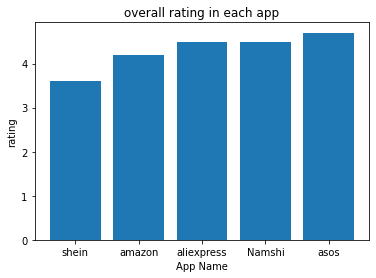

In [4]:
x= df['AppName']
y=df['OverallRate']
plt.bar(x,y)
plt.title('overall rating in each app')
plt.xlabel('App Name')
plt.ylabel('rating')

Text(0.5, 1.0, 'Number of rating')

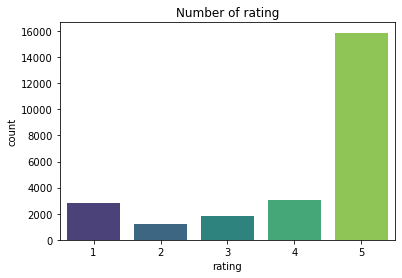

In [105]:
sns.countplot(x='rating',data=df,palette='viridis')
plt.title('Number of rating')


## Split the data

In [3]:
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [4]:
training_data.groupby(['AppName']).count()["OverallRate"]

AppName
Namshi         925
aliexpress    5752
amazon        3995
asos          2221
shein         6906
Name: OverallRate, dtype: int64

In [12]:
training_data.count()

AppName              19799
date                 19799
time                 19799
PmAm                 19799
title                19799
userName             19799
rating               19799
review               19799
isEdited             19799
developerResponse     6630
OverallRate          19799
dtype: int64

In [36]:
testing_data.groupby(['AppName']).count()["OverallRate"]

AppName
Namshi         244
aliexpress    1468
amazon        1005
asos           519
shein         1714
Name: OverallRate, dtype: int64

In [13]:
testing_data.count()

AppName              4950
date                 4950
time                 4950
PmAm                 4950
title                4950
userName             4950
rating               4950
review               4950
isEdited             4950
developerResponse    1716
OverallRate          4950
dtype: int64

## Text Preprocessing

In [5]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_review(review, flg_stemm=False, flg_lemm=True, lst_stopwords= None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    review = re.sub(r'[^\w\s]', '', str(review).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_review = review.split()
    
    ## remove Stopwords
    if lst_stopwords is not None :
        lst_review = [word for word in lst_review if word not in 
                    lst_stopwords]
        
        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_review = [ps.stem(word) for word in lst_review]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_review = [lem.lemmatize(word) for word in lst_review]
            
    ## back to string from list
    review = " ".join(lst_review)
    return review

In [6]:
training_data["review_clean"] = training_data["review"].apply(lambda x: utils_preprocess_review(x, flg_stemm=False, flg_lemm=True, lst_stopwords= None))

In [7]:
# apply stopwords
stop = stopwords.words('english')
training_data['review_clean'] = training_data['review_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
training_data.head(5)

,AppName,date,time,PmAm,title,userName,rating,review,isEdited,developerResponse,OverallRate,review_clean
22085,asos,06/08/2020 0:00,7:32:04,AM,Not happy,Loulabug78,5,Placed an order for 3 items and paid for it al...,False,NaN,4.7,placed order 3 item paid suuday 2nd august rec...
21604,Namshi,06/02/2018 0:00,5:30:33,PM,المحاميد,الفوا,4,Subaie,False,NaN,4.5,subaie
15159,aliexpress,22/10/2020 0:00,3:07:39,AM,Scam,wheres my Money.,1,Most of the vendors on there are Scammers. Whe...,False,wheres my Money.,4.5,vendor scammer pay hair 2 week later tell stoc...
11832,amazon,13/12/2020 0:00,4:37:54,AM,Customer service,Jgfbffjerhhjj,5,I had ordered a item that never showed up cont...,False,NaN,4.2,ordered item never showed contact customer ser...
2041,shein,11/01/2022 0:00,9:48:03,PM,Great place to Shop,juliem200,5,I love SHEIN its a great place for shopping fo...,False,NaN,3.6,love shein great place shopping everyone famil...


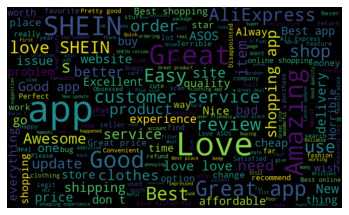

In [23]:
# Most frequent words
words=' '.join( [x for x in training_data["title"]] )
wordcloud=WordCloud(width=1000, height=600, random_state=10, max_font_size=110).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

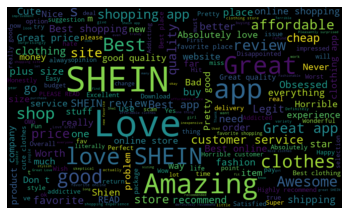

In [32]:
#shein most frequent words
df_shein= training_data[training_data["AppName"]=='shein']
words=' '.join( [x for x in df_shein["title"]] )
wordcloud=WordCloud(width=1000, height=600, random_state=10, max_font_size=110).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

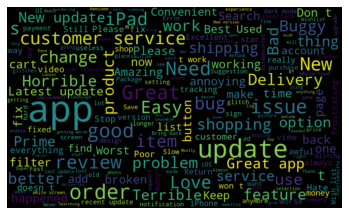

In [34]:
#amazon most frequent words
df_amazon= training_data[training_data["AppName"]=='amazon']
words=' '.join( [x for x in df_amazon["title"]] )
wordcloud=WordCloud(width=1000, height=600, random_state=10, max_font_size=110).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

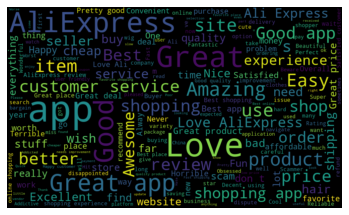

In [39]:
#amazon most frequent words
df_aliexpress= training_data[training_data["AppName"]=='aliexpress']
words=' '.join( [x for x in df_aliexpress["title"]] )
wordcloud=WordCloud(width=1000, height=600, random_state=10, max_font_size=110).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

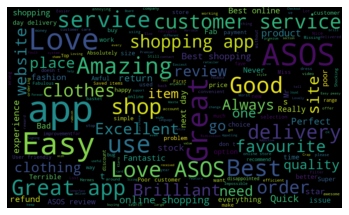

In [40]:
#asos most frequent words
df_asos= training_data[training_data["AppName"]=='asos']
words=' '.join( [x for x in df_asos["title"]] )
wordcloud=WordCloud(width=1000, height=600, random_state=10, max_font_size=110).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

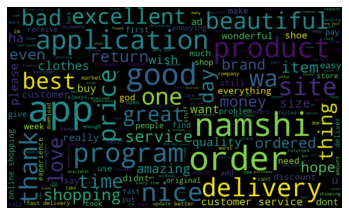

In [43]:
#Namshi most frequent words
df_namshi= training_data[training_data["AppName"]=='Namshi']
words=' '.join( [x for x in df_namshi["review_clean"]] )
wordcloud=WordCloud(width=1000, height=600, random_state=10, max_font_size=110).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Length Analysis

In [8]:
# word count: counts the number of tokens in the text (separated by a space)
#character count: sum the number of characters of each token
# sentence count: count the number of sentences (separated by a period)
# average word length: sum of words length divided by the number of words (character count/word count)
# average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count)

training_data['word_count'] = training_data["review_clean"].apply(lambda x: len(str(x).split(" ")))
training_data['char_count'] = training_data["review_clean"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
training_data['sentence_count'] = training_data["review_clean"].apply(lambda x: len(str(x).split(".")))
training_data['avg_word_length'] = training_data['char_count'] / training_data['word_count']
training_data['avg_sentence_lenght'] = training_data['word_count'] / training_data['sentence_count']

training_data.head()

,AppName,date,time,PmAm,title,userName,rating,review,isEdited,developerResponse,OverallRate,review_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
22085,asos,06/08/2020 0:00,7:32:04,AM,Not happy,Loulabug78,5,Placed an order for 3 items and paid for it al...,False,NaN,4.7,placed order 3 item paid suuday 2nd august rec...,50,250,1,5.000000,50.0
21604,Namshi,06/02/2018 0:00,5:30:33,PM,المحاميد,الفوا,4,Subaie,False,NaN,4.5,subaie,1,6,1,6.000000,1.0
15159,aliexpress,22/10/2020 0:00,3:07:39,AM,Scam,wheres my Money.,1,Most of the vendors on there are Scammers. Whe...,False,wheres my Money.,4.5,vendor scammer pay hair 2 week later tell stoc...,50,227,1,4.540000,50.0
11832,amazon,13/12/2020 0:00,4:37:54,AM,Customer service,Jgfbffjerhhjj,5,I had ordered a item that never showed up cont...,False,NaN,4.2,ordered item never showed contact customer ser...,18,89,1,4.944444,18.0
2041,shein,11/01/2022 0:00,9:48:03,PM,Great place to Shop,juliem200,5,I love SHEIN its a great place for shopping fo...,False,NaN,3.6,love shein great place shopping everyone famil...,42,224,1,5.333333,42.0


## implement TextBlob

In [12]:
'''
# Sentiment analysis
# TextBlob Exit will return polarity and subjectivity.
# Polarity indicates your mood, that is, whether it is positive.
# It returns a value between 0 and 1. The closer to 1 the more positive, the closer to 0 the more negative.
'''

training_data[['polarity', 'subjectivity']] = training_data['review_clean'].apply(lambda x: pd.Series(TextBlob(x).sentiment))

for index, row in training_data['review_clean'].iteritems():

    score = SentimentIntensityAnalyzer().polarity_scores(row)

    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    if neg > pos:
        training_data.loc[index, 'sentiment'] = "Negative"
    elif pos > neg:
        training_data.loc[index, 'sentiment'] = "Positive"
    else:
        training_data.loc[index, 'sentiment'] = "neutral"

In [47]:
training_data

,AppName,date,time,PmAm,title,userName,rating,review,isEdited,developerResponse,OverallRate,review_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,polarity,subjectivity,sentiment
22085,asos,06/08/2020 0:00,7:32:04,AM,Not happy,Loulabug78,5,Placed an order for 3 items and paid for it al...,False,NaN,4.7,placed order 3 item paid suuday 2nd august rec...,50,250,1,5.000000,50.0,0.060000,0.577778,Positive
21604,Namshi,06/02/2018 0:00,5:30:33,PM,المحاميد,الفوا,4,Subaie,False,NaN,4.5,subaie,1,6,1,6.000000,1.0,0.000000,0.000000,neutral
15159,aliexpress,22/10/2020 0:00,3:07:39,AM,Scam,wheres my Money.,1,Most of the vendors on there are Scammers. Whe...,False,wheres my Money.,4.5,vendor scammer pay hair 2 week later tell stoc...,50,227,1,4.540000,50.0,-0.073214,0.279167,Negative
11832,amazon,13/12/2020 0:00,4:37:54,AM,Customer service,Jgfbffjerhhjj,5,I had ordered a item that never showed up cont...,False,NaN,4.2,ordered item never showed contact customer ser...,18,89,1,4.944444,18.0,0.568182,0.377273,Positive
2041,shein,11/01/2022 0:00,9:48:03,PM,Great place to Shop,juliem200,5,I love SHEIN its a great place for shopping fo...,False,NaN,3.6,love shein great place shopping everyone famil...,42,224,1,5.333333,42.0,0.435795,0.488068,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21245,Namshi,26/04/2015 0:00,3:55:37,PM,Saudi arabia,ABEER',5,Really beautiful🍃,False,NaN,4.5,really beautiful,2,15,1,7.500000,2.0,0.850000,1.000000,Positive
23468,asos,04/10/2018 0:00,1:21:42,PM,Plus size,housing queen,5,This company makes the best plus size clothing...,False,NaN,4.7,company make best plus size clothingi always p...,23,125,1,5.434783,23.0,0.521429,0.683929,Positive
1175,shein,21/09/2019 0:00,10:02:51,AM,Avid SheIn Shopper!,Kb Katrice,5,It’s fast fashion and they always have the lat...,False,NaN,3.6,fast fashion always latest trend affordable pr...,61,321,1,5.262295,61.0,0.204945,0.617582,Positive
2934,shein,07/11/2021 0:00,8:25:53,PM,SHEIN,dandra nelson,5,"Dear SHEIN , your clothes are amazing I love h...",False,NaN,3.6,dear shein clothes amazing love price low pric...,36,174,1,4.833333,36.0,0.383333,0.533333,Positive


In [13]:
training_data.groupby(["sentiment"])['AppName'].count()

sentiment
Negative     2866
Positive    16459
neutral       474
Name: AppName, dtype: int64

In [97]:
df_namshi= training_data[training_data["AppName"]=='Namshi']
df_asos= training_data[training_data["AppName"]=='asos']
df_aliexpress= training_data[training_data["AppName"]=='aliexpress']
df_amazon= training_data[training_data["AppName"]=='amazon']
df_shein= training_data[training_data["AppName"]=='shein']

In [98]:
#namshi sentmint
df_namshi.groupby(["sentiment"])['AppName'].count()

sentiment
Negative    147
Positive    602
neutral     176
Name: AppName, dtype: int64

In [99]:
df_asos.groupby(["sentiment"])['AppName'].count()

sentiment
Negative     295
Positive    1863
neutral       63
Name: AppName, dtype: int64

In [100]:
df_aliexpress.groupby(["sentiment"])['AppName'].count()

sentiment
Negative     715
Positive    4947
neutral       90
Name: AppName, dtype: int64

In [101]:
df_amazon.groupby(["sentiment"])['AppName'].count()

sentiment
Negative    1267
Positive    2594
neutral      134
Name: AppName, dtype: int64

In [103]:
df_shein.groupby(["sentiment"])['AppName'].count()

sentiment
Negative     442
Positive    6453
neutral       11
Name: AppName, dtype: int64

## Word Frequency

In [14]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
  print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [15]:
positiveValues=defaultdict(int)
negativeValues=defaultdict(int)
neutralValues=defaultdict(int)
#get the count of every word in both the columns of training_data and testing_data dataframes

In [ ]:
#get the count of every word in both the columns of training_data and testing_data dataframes where sentiment="Negative"
for text in training_data[training_data.sentiment=="Positive"].review_clean:
  for word in generate_N_grams(text):
    positiveValues[word]+=1

In [16]:
df_positive=pd.DataFrame(sorted(positiveValues.items(),key=lambda x:x[1],reverse=True))

In [ ]:
pd1=df_positive[0][:10]
pd2=df_positive[1][:10]

In [75]:
#get the count of every word in both the columns of training_data and testing_data dataframes where sentiment="Negative"
for text in training_data[training_data.sentiment=="Negative"].review_clean:
  for word in generate_N_grams(text):
    negativeValues[word]+=1

Sentence after removing stopwords: ['vendor', 'scammer', 'pay', 'hair', '2', 'week', 'later', 'tell', 'stock', 'way', 'get', 'money', 'back', 'disturb', 'way', 'mean', 'lie', 'dont', 'look', 'bad', 'dont', 'say', 'wouldnt', 'give', 'money', 'ha', 'happened', 'many', 'time', 'try', 'get', 'touch', 'aliexpress', 'deleted', 'number', 'email', 'robot', 'doesnt', 'even', 'respond', 'call', 'bank', 'pay', 'extra', 'money', 'get', 'money', 'back', 'pick', 'vendor']
Sentence after removing stopwords: ['convenient', 'siteapp', 'buy', 'stuff', 'whenever', 'see', 'clothes', 'jewelry', 'namebrand', 'ad', 'screenshot', 'use', 'photo', 'search', 'aliexpress', 'find', 'much', 'cheaper', 'avoid', 'dropshipping', 'scam']
Sentence after removing stopwords: ['latest', 'update', 'app', 'force', 'app', 'use', 'portrait', 'mode', 'cut', 'bottom', 'screen', 'making', 'difficult', 'shop', 'deleted', 'readded', 'see', 'fix', 'ala', 'please', 'bring', 'fully', 'functional', 'landscape', 'mode', 'back', 'app', '

In [76]:
df_negative=pd.DataFrame(sorted(negativeValues.items(),key=lambda x:x[1],reverse=True))

In [77]:
ned1=df_negative[0][:10]
ned2=df_negative[1][:10]

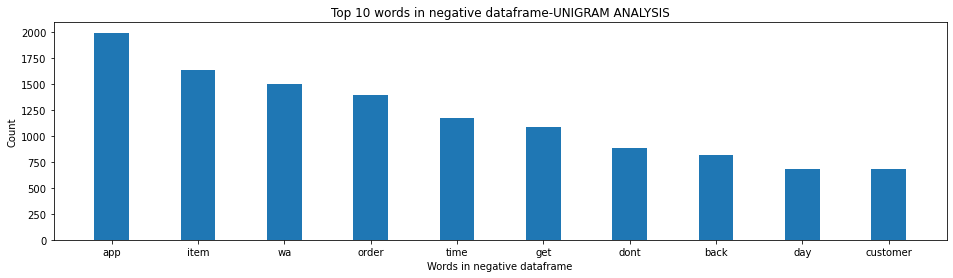

In [78]:
plt.figure(1,figsize=(16,4))
plt.bar(ned1,ned2,
        width = 0.4)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-UNIGRAM ANALYSIS")
plt.savefig("negative-unigram.png")
plt.show()

In [70]:
#get the count of every word in both the columns of training_data and testing_data dataframes where sentiment="neutral"
for text in training_data[training_data.sentiment=="neutral"].review_clean:
  for word in generate_N_grams(text):
    neutralValues[word]+=1

Sentence after removing stopwords: ['subaie']
Sentence after removing stopwords: ['shopping', 'price', 'high']
Sentence after removing stopwords: ['']
Sentence after removing stopwords: ['get', 'clothes', 'asos', 'everything', 'name', 'quick', 'release', 'thing', 'trendy']
Sentence after removing stopwords: ['looking', 'something', 'dont', 'estimate', 'site', 'thing', 'likely']
Sentence after removing stopwords: ['purchased', '50', 'item', 'last', 'year', 'app', 'website', 'issue', 'refunded', 'money', 'every', 'time', 'issue']
Sentence after removing stopwords: ['cant', 'return', 'product']
Sentence after removing stopwords: ['niceee']
Sentence after removing stopwords: ['fdcff']
Sentence after removing stopwords: ['ipad', 'version', 'doe', 'show', 'customer', 'image', 'item', 'review', 'page', 'latest', 'update', 'click', 'image', 'item', 'description', 'page', 'brings', 'detail', 'last', 'item', 'looked', 'current', 'item']
Sentence after removing stopwords: ['stuff', 'order', 'take

In [71]:
df_neutral=pd.DataFrame(sorted(neutralValues.items(),key=lambda x:x[1],reverse=True))

In [72]:
nud1=df_neutral[0][:10]
nud2=df_neutral[1][:10]

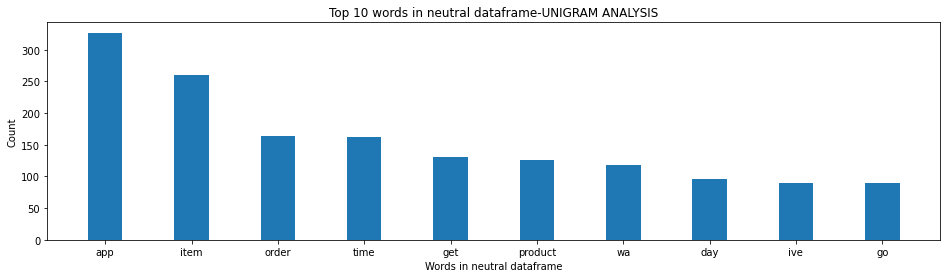

In [74]:
plt.figure(1,figsize=(16,4))
plt.bar(nud1,nud2,
        width = 0.4)
plt.xlabel("Words in neutral dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in neutral dataframe-UNIGRAM ANALYSIS")
plt.savefig("neutral-unigram.png")
plt.show()

## Topic Modeling

In [28]:
AppName= "asos"
corpus = training_data[training_data["AppName"]==AppName]["review_clean"]

In [29]:
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [30]:
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)

In [31]:
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [32]:
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [34]:
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

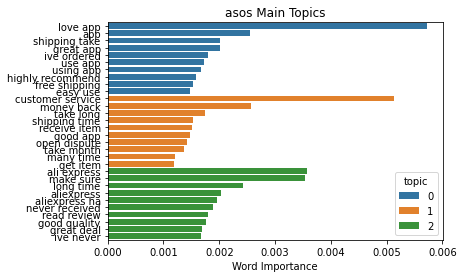

In [69]:
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('asos Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [38]:
AppName= "Namshi"
corpus = training_data[training_data["AppName"]==AppName]["review_clean"]

In [39]:
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [40]:
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)

In [41]:
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [42]:
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [43]:
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

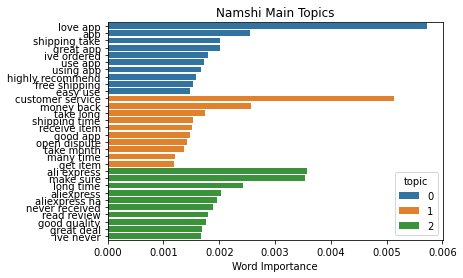

In [68]:
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Namshi Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [55]:
AppName= "amazon"
corpus = training_data[training_data["AppName"]==AppName]["review_clean"]

In [56]:
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [57]:
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [58]:
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

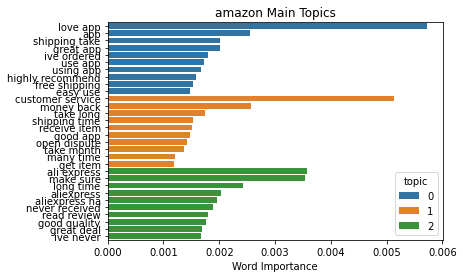

In [67]:
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('amazon Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [60]:
AppName= "aliexpress"
corpus = training_data[training_data["AppName"]==AppName]["review_clean"]

In [61]:
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [62]:
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [63]:
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [64]:
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

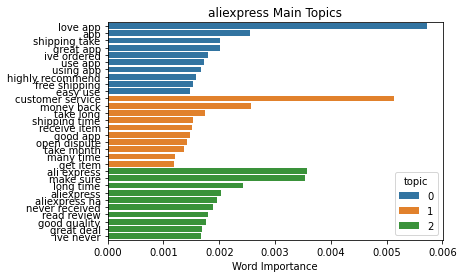

In [66]:
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('aliexpress Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [70]:
AppName= "shein"
corpus = training_data[training_data["AppName"]==AppName]["review_clean"]

In [71]:
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [72]:
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [73]:
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   

In [74]:
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

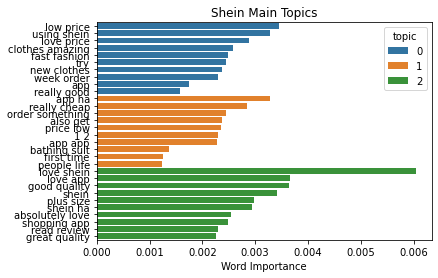

In [76]:
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Shein Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()